# Introduction
In this notebook we will be examing how to improve the quality of analaysis for draft data provided very generously by 17Lands(https://www.17lands.com/public_datasets) under the creative commons liscence. 17Lands in no way endorses me or my use of their data.

Currently there are several metrics which are used to determine how good a card is. These metrics are grounded in quadrant theory(https://strategy.channelfireball.com/all-strategy/mtg/quadrant-theory-revisited/) which seeks to determine how good a card is at different stages of the game. The currently proposed metrics are:
 - Improvement when drawn (bias towards late game closers)
 - Winrate when card is in deck (unbiased)
 - Winrate in starting hand (biased toward the early game)

What I will seek to show in this notebook is the answer to the question: Can you generate an unbiased winrate from the cards in hand?

# Bias
In the introduction we referenced that the currently proposed metrics are biased toward the early, lategame, or unbiased. To determine an unbiased metric we must answer an equivilent question: How exactly is a sampling metric biased toward the early or late game?

To calculate this we must first idenitfy a useful framework for calculating the bias of a metric. 

## Calculating Bias Derevation

For the next section I will use a math notation where:

$P(A|b,c,...)$ : The probability of $A$, given a set of conditions $b,c...$

$C_i$ - A particular card chosen from the set to evaluate

$Draw_{C_i}$ - The condition of Drawing a Card $C_i$ after the game has started

$E_{C_i}$ - The condition of $C_i$ ever seeing in hand. Ever in Hand.

$Deck_{C_i}$ - The condition of a deck containing a Card, $C_i$

$W$ - The condition of winning

$T_n$ - The condition of the game ending on Turn N


For the purposes of this notebook, let us consider an estimate for the winrate of a deck given that it has ever had card $C_i$ in hand, $P(W|E_{C_i})$, to be unbiased if and only if it accuratly represents the probability that that event will occur in any given a game of Magic. Given this assumption, are going to calculate the unbiased probability of $P(W|E_{C_i})$ in terms of data we can sample from the 17Lands data set. 

To simplify this calculation, we will introduce the subproblem where we always draw $C_i$ and all games end on Turn $N$.

This subproblem makes it much easier to calculate the probability of ever having a card $C_i$ in hand if we assume for the sake of simplicity: 
- On average the number of cards in hand on turn $N$ is $N + 7$
- You only have one copy of the card in the deck
- Your deck has 40 cards

$$P( E_{C_i}|T_n) = \frac{N+7}{40}$$

To calculate the total winrate using the subproblem, we can just notice that the game will end on or before turn 33 since you only have 40 cards in deck. This means that for any game that ends on turn $N$, the winrate for that turn can be described as the probability a game will end on that turn given that $C_i$ was ever in hand multiplied by the probability that you won on that turn.

So all possible outcomes are accounted for by the following sum of products:
$$P(W|E_{C_i}) = \left(P(T_1|E_{C_1})\cdot P(W|T_1,E_{C_i}) \right) + \left(P(T_2|E_{C_1})\cdot P(W|T_2,E_{C_i}) \right) + ... + \left(P(T_{33}|E_{C_1}) \cdot P(W|T_{33},E_{C_i})\right)$$

Simplifying the equation
$$P(W| E_{C_i} )= \sum_{n=1}^{33}P(T_n | E_{C_i}) \cdot P(W|E_{C_i},T_n) $$

Using Bayes Theorm:
$$ P(T_n| E_{C_i}) = \frac{P(E_{C_i} | T_n) \cdot P(T_n)}{P(E_{C_i})} $$

Using a similar divide and conquor strategy we can find $P(E_{C_i})$ by summing over $T_n$ we use $m$ instead of $n$ in this sum so we can embed this equation in a larger sum when we substitute in a later step.

$$P(E_{C_i}) = \sum^{33}_{m=0} P(T_m) \cdot P(E_{C_i} | T_m)$$

Substituting $P( E_{C_i}|T_n)$
$$P(E_{C_i}) = \sum^{33}_{m=0} \frac{\left( M+7 \right) \cdot P(T_m)}{40}$$

Substuting $P(E_{C_i})$ into $P(T_n| E_{C_i})$
$$ P(T_n| E_{C_i}) = \frac{P(E_{C_i} | T_n) \cdot P(T_n)}{\sum^{33}_{m=0} \frac{\left(M+7\right) \cdot P(T_m)}{40}} $$

Substuting $P( E_{C_i}|T_n)$ into $P(T_n| E_{C_i})$
$$ P(T_n| E_{C_i}) = \frac{(N+7) \cdot P(T_n)}{\sum^{33}_{m=0} \left(M+7\right) \cdot P(T_m)} $$

Substituting $P(T_n| E_{C_i})$ back into the sum of products
$$P(W| E_{C_i} )= \sum_{n=1}^{33}\frac{(N+7) \cdot P(T_n)}{\sum^{33}_{m=0} \left(M+7\right) \cdot P(T_m)} \cdot P(W|E_{C_i},T_n) $$

Though this equation looks like it's not better, we can sample $P(T_n)$, $P(W|E_{C_i},T_n)$ on the data set by just sorting the data based on turn length. Sampling the data provided by 17Lands as shown in the next section of the notebook.

## Application of Bias Calculation
To give some context to bias calculation discussion, we will extract some live data from the KHM limited format and plot them to show what our analysis looks like on real data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
Utility functions

Functions that are used throughout the notebook are put here to try to reduce clutter in later analysis
'''
# Game data from https://www.17lands.com/public_datasets
game_data_filename = 'game_data_public.KHM.PremierDraft.csv'
# UG kaldheim cardnames retreived with the scryfall api
khm_ug = pd.read_csv("khm_ug.csv")
# RW kaldheim cardnames retreived with the scryfall api
khm_rw = pd.read_csv("khm_rw.csv")

#####################################################################################################
# This function returns an iterator with a batch of data. Batching makes intermittent steps easier to
# examine for correctness and also allows for a "loading bar" to post incremental progress
#
# \param[in] chunksize - Size of the chunk of data to process. Optional with default 2000
#
# \return dataiter - an iterator that returns data frames containing batches of cards 
def getDataIter(chunksize = 2000):
    dataiter = pd.read_csv(game_data_filename,chunksize=chunksize)
    return dataiter

#####################################################################################################
# Get list of card names
#
# \param[in] df     The data you are getting the card names from
# \param[in] prefix An optional prefix to prepend to the card names 
#
# \return A list of card names
def get_card_name_list(df, prefix=""):
    cards = [prefix+col.replace("deck_","") for col in df.columns if 'deck' in col]
    return cards

In [3]:
'''
Raw Calculations

Calculate the winrates we are going to use for the rest of the notebook
'''
#####################################################################################################
# Add columns to track the winrate of each card
#
# \param[in] df The data to add a column to
#
# \return The data with columns added to track the winrate of each card
def add_col_winrate_when_in_hand(df):
    # Generate list for new column names
    in_hand = get_card_name_list(df,"in_hand_")
    # Add the cards that are either drawn or in opening hand
    df[in_hand] = \
        df[get_card_name_list(df,"drawn_")].to_numpy() \
        + df[get_card_name_list(df,"opening_hand_")].to_numpy()
    # Flatten the data to only detect if the card was drawn and not care about quantity
    df[in_hand] = df[in_hand] > 0
    # Convert to Int
    df[in_hand] = df[in_hand].to_numpy(dtype=int)
    # Store win/loss for each game
    # Storing the data in an additional column helps when we aggregate the data in a later step by
    # accumulating it in a column as opposed to a local variable
    ihw = get_card_name_list(df,"ihw_")
    df[ihw] = df[in_hand].mul(df["won"],axis=0)
    return df
    
# Group the data by number of turns
# Add a num_games column to track the number of games that took a particular length
def group_num_turns(df):
    df["num_games"] = 1
    df = df.groupby(by="num_turns").sum()
    return df

data_iter = getDataIter()
data_grouped_by_turn_count = next(data_iter)
# Filter by columns that we are performing calculations on
filtered_columns = sum([ \
                        get_card_name_list(data_grouped_by_turn_count,"deck_"),
                        get_card_name_list(data_grouped_by_turn_count,"opening_hand_"),
                        get_card_name_list(data_grouped_by_turn_count,"drawn_"),
                        ["won","num_turns"]
                       ], [])
data_grouped_by_turn_count = data_grouped_by_turn_count[filtered_columns]
data_grouped_by_turn_count = add_col_winrate_when_in_hand(data_grouped_by_turn_count)
data_grouped_by_turn_count = group_num_turns(data_grouped_by_turn_count)
# Used to track progress
counter = 0
for batch in data_iter:
    print(counter,end=" ")
    batch = batch[filtered_columns]
    batch = add_col_winrate_when_in_hand(batch)
    batch = group_num_turns(batch)
    data_grouped_by_turn_count = data_grouped_by_turn_count.add(batch,fill_value=0)
    counter += 1



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 

### Turn End Distrubution
This is the distribution of what turn the game ended on or $T_n$

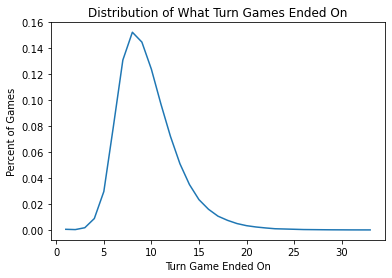

In [4]:
turn_dist = data_grouped_by_turn_count["num_games"]
# Total of all probabilities = 1
turn_dist = turn_dist/turn_dist.sum()
plt.plot(turn_dist.index, turn_dist)
plt.title('Distribution of What Turn Games Ended On')
plt.ylabel('Percent of Games')
plt.xlabel("Turn Game Ended On")
plt.show()


### Sample Winrates by Turn
Having calculated the probabilty of winning with a card ever in your hand on turn $N$, or $P(W, E_{C_i}, T_n)$ for each card $C_i$, we plot a selection of cards from the set to show some data points. As you can see, battlefield raptor is good at the start of the game, but drops off in power level as the game goes longer. Ravenous Lindwurm really spikes in power level as the game goes on. This is consistent with what you expect from the cards. Also not that you there are less samples for longer/shorter games, the data is noisier in this case we chose to cut it off, but you can feel free to add it back if you download the notebook.

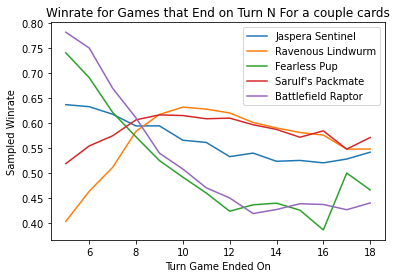

In [5]:
# This is the winrate of a couple cards over the range of number of turns
# Cards selected were arbitrary, but I attempted to select cards I expect to have different winrate shapes over 
# the course of the game
card_list = ["Jaspera Sentinel",\
             "Ravenous Lindwurm",\
             "Fearless Pup",\
             "Sarulf's Packmate",\
             "Battlefield Raptor"]
# Remove shorter games for lack of data
START = 4
# Cutoff longer games for lack of data
CUTOFF = 18
graphs = []
for card in card_list:
    winrate = data_grouped_by_turn_count["ihw_"+card].to_numpy()\
                /(data_grouped_by_turn_count["in_hand_"+card].to_numpy() + 0.000000001) # Divide by Zero Bugfix
    graphs += plt.plot(data_grouped_by_turn_count.index[START:CUTOFF], winrate[START:CUTOFF], label=card)
plt.title('Winrate for Games that End on Turn N For a couple cards')
plt.ylabel('Sampled Winrate')
plt.xlabel("Turn Game Ended On")
plt.legend(handles=graphs)
plt.show()


## Calculating the Bias of "Winrate When Drawn"
To calculate the bias of winrate for "Winrate when drawn" you simply have to calculate the difference between the winrate when drawn and the unbiased winrate for any particular card. To simplify this calculation, using the previously proposed framework, we will first solve the subproblem of what is the overrepresentation of games which end on turn $N$. 

To find the overrepresentation of samples for a game that ends turn $N$ you find the likelyhood you will sample a game that ends on turn $N$ given that the sample was taken from a pool of samples where the game ended. The derevation for $P(Draw_{C_i})$ are the same as above.
$$P(T_n| Draw_{C_i}) = \frac{P(T_n) \cdot P(Draw_{C_i} | T_n) }{\sum^{\infty}_{m=1} P(T_m) \cdot P(Draw_{C_i}| T_m)}$$

Further we will assume for calculating the probability of drawning a card on turn $N$:
- On average the number of chances you have had to draw $C_i$ on turn $N$ is $N$ (one card per turn)
- You only have one copy of the card in the deck
- Your deck has 40 cards

$$P( Draw_{C_i}|T_n) = \frac{N}{40}$$

Thus the winrate of "Winrate when drawn" is the probabilty you will win on turn $N$ times the rate at which you sample games that end on turn $N$.
$$ P(W|Draw_{C_i}) = \sum^{33}_{n=1} P(T_n| Draw_{C_i}) \cdot P(W|Draw_{C_i}, T_n) $$ 

After several substitutions similar to the the above equation we get:
$$P(W| Draw_{C_i} )= \sum_{n=1}^{33}\frac{N \cdot P(T_n)}{\sum^{33}_{m=0} M \cdot P(T_m)} \cdot P(W|Draw_{C_i},T_n) $$

To calculate the bias of a metric, let us assume, without loss of generality, that a card has an $N$ dimentional winrate vector of $\vec{W}$ where $W_n$ is the winrate of a card when the game ends on turn $N$. 

Let us then consider bias vector $\vec{B}$ where the $N$th element of $\vec{B}$, $B_n$ is the expected difference between a proposed metric for measuring winrate, and the unbiased winrate measure.

$$B_n = P(T_n| Biased Winrate Metric_{C_i}) - P(T_n | E_{C_i})\cdot $$

This allows us to, for a given Winrate vector $\vec{W}$ calculate the bias toward that particular card by doing the dot product of $\vec{B}\cdot \vec{W}$

In [18]:
# In this section we will show how to calculate the bias vector of a winrate metric, \vec{B}, 
# given that we have done the derevation

# Calculate the unbiased winrate using the equations derived above
unbiased_denominator = np.dot(turn_dist.to_numpy(),np.arange(8,41))
unbiased_winrate = (1/unbiased_denominator)*np.arange(8,41)*turn_dist

# Calculate the biased winrate using the equations derived above
bias_demoninator_drawn = sum(turn_dist.to_numpy()*np.arange(1,34))
winrate_when_drawn = (1/bias_demoninator_drawn)*np.arange(1,34)*turn_dist


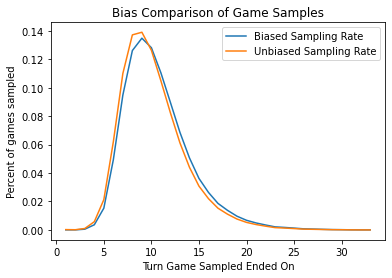

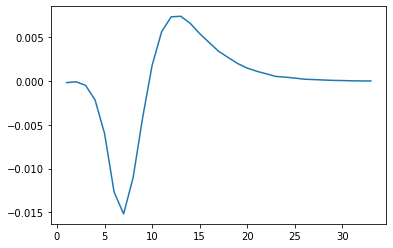

Jaspera Sentinel -0.004933702340617645
Ravenous Lindwurm 0.0038889797644560313
Fearless Pup -0.010133097021440104
Sarulf's Packmate 0.00022905980344363046
Battlefield Raptor -0.012467627780046899


In [19]:
graphs = []
graphs += plt.plot(winrate_when_drawn, label="Biased Sampling Rate")
graphs += plt.plot(unbiased_winrate,label="Unbiased Sampling Rate")
plt.title('Bias Comparison of Game Samples')
plt.ylabel('Percent of games sampled')
plt.xlabel("Turn Game Sampled Ended On")
plt.legend(handles=graphs)
plt.show()

# Plot of B
bias = winrate_when_drawn - unbiased_winrate
plt.plot(bias)
plt.show() 
# Since the bias of a winrate metric for a particular card is \vec{B} * \vec{W} we will calculate the 
# bias of the proposed winrate for the same cards we graphed above
for card in card_list:
    winrate = data_grouped_by_turn_count["ihw_"+card].to_numpy()\
                /(data_grouped_by_turn_count["in_hand_"+card].to_numpy() + 0.000000001) # Divide by Zero Bugfix
    print(card, np.dot(bias,winrate))

## Selecting a better sampling weighting for early/late game.
As You can see, the winrate of these cards were only biased by +-1%. This is technically biased, but perhaps not as drastically biased as you might expect if you were going around telling people "Oh this metric is biased toward the late game, you probably shouldn't use it". 

A common practice in signal processing to isolate a desired signal, is choosing the response you want from a function in a target domain and back calculating the weighting of your sampling to have that desired response. I am proposing two new weightings which will both only consider performance in the early and late game and ignore any other turns. The trick is to take the unbaised sampling weights, and 0 out everything before or after the median turn where games are won. 

The median turn is calculated by looking at the cumlative sum for the unbiased win estimator and identifying the 50%. 

The calculations are shown in the cells below.

In [20]:
# Median turn (about 9)
median_turn = unbiased_winrate.cumsum()
median_turn[6:10]

num_turns
7     0.200631
8     0.337802
9     0.476823
10    0.603170
Name: num_games, dtype: float64

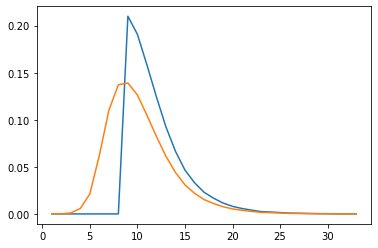

Jaspera Sentinel -0.02052319561123228
Ravenous Lindwurm 0.028699819929729472
Fearless Pup -0.05246485320528218
Sarulf's Packmate 0.006700354887401985
Battlefield Raptor -0.06480275145361344


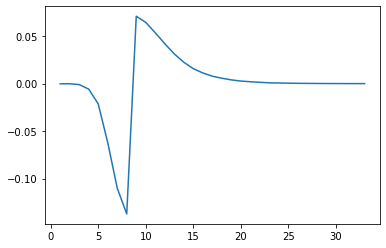

In [21]:
# Late Game Biased Estimator
late_game_bias = unbiased_winrate*(median_turn>0.48)
late_game_bias = late_game_bias/sum(late_game_bias)
graphs = [plt.plot(late_game_bias, label="Biased Sampling Rate"),\
         plt.plot(unbiased_winrate,label="Unbiased Sampling Rate")]
plt.show()

# Plot of B
bias = late_game_bias - unbiased_winrate
plt.plot(bias)

# Since the bias of a winrate metric for a particular card is \vec{B} * \vec{W} we will calculate the 
# bias of the proposed winrate for the same cards we graphed above
for card in card_list:
    winrate = data_grouped_by_turn_count["ihw_"+card].to_numpy()\
                /(data_grouped_by_turn_count["in_hand_"+card].to_numpy() + 0.000000001) # Divide by Zero Bugfix
    print(card, np.dot(bias,winrate))

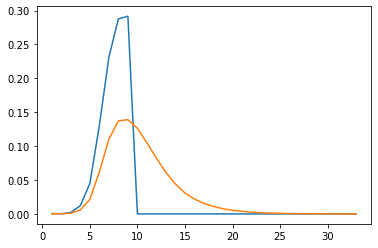

Jaspera Sentinel 0.03414579918081332
Ravenous Lindwurm -0.02934096642157052
Fearless Pup 0.07376415990241293
Sarulf's Packmate -0.0031241204032018918
Battlefield Raptor 0.08912267026510087


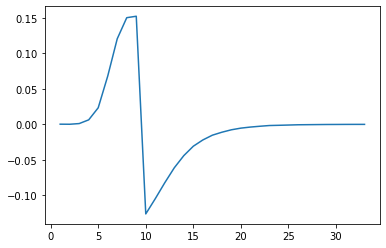

In [22]:
# Early Game Biased Estimator
early_game_bias = unbiased_winrate*(median_turn<0.55)
early_game_bias = early_game_bias/sum(early_game_bias)
graphs = [plt.plot(early_game_bias, label="Biased Sampling Rate"),\
         plt.plot(unbiased_winrate,label="Unbiased Sampling Rate")]
graphs
plt.show()

# Plot of B
bias = early_game_bias - unbiased_winrate
plt.plot(bias)

# Since the bias of a winrate metric for a particular card is \vec{B} * \vec{W} we will calculate the 
# bias of the proposed winrate for the same cards we graphed above
for card in card_list:
    winrate = data_grouped_by_turn_count["ihw_"+card].to_numpy()\
                /(data_grouped_by_turn_count["in_hand_"+card].to_numpy() + 0.000000001) # Divide by Zero Bugfix
    print(card, np.dot(bias,winrate))

### Calculation on data
Here we apply the proposed winrates to the kaldheim data set and correlate it with in deck winrate. RW and UG are chosen to signify types of cards that are good in the "early" / "late" game.

In [23]:
#####################################################################################################
# Add columns to track the winrate of each card given a weighted metric
#
# \param[in] data            The data to a weighted metric to
# \param[in] name            The name of the metric
# \param[in] weighted_metric The metric you are using to weight your date
#
# \return The data with columns added to track the winrate of each card
def add_cards_weighted_metric(data, name, weighted_metric):  
    # Add a weight column to allow in place calculation of how to weigh each sample
    # print(weighted_metric, weighted_metric[1])
    data[name+"_weight"] = data["num_turns"].apply(lambda x : weighted_metric[x])
    # Populate the sample column
    sample_col = get_card_name_list(data, name+"_")
    data[sample_col] = \
        data[get_card_name_list(data,"drawn_")].to_numpy() \
        + data[get_card_name_list(data,"opening_hand_")].to_numpy()
    # Flatten the data to only detect if the card was drawn and not care about quantity
    data[sample_col] = data[sample_col] > 0
    # Weight the date based on the weighted metric
    data[sample_col] = data[sample_col].mul(data[name+"_weight"], axis=0)
    # Populate the winrate column
    won_col = get_card_name_list(data, name+"_win_")
    data[won_col] = data[sample_col].mul(data["won"],axis=0)
    return data

#####################################################################################################
# Add columns to track the winrate of each card in the deck
#
# \param[in] data The data to add in deck winrate to
#
# \return The data with columns added to track the winrate of each card in deck
def add_idw(data):
    cards = [col.replace("deck_","") for col in data.columns if 'deck' in col]
    idw_col = ["idw_won_" + col for col in cards]
    data[idw_col] = data.loc[:,data.columns.str.contains("deck")].mul(data["won"],axis=0)
    return data

#####################################################################################################
# Helper function to add columns to track the winrate of each card in the deck
#
# \param[in] data The data to add columns to
#
# \return The data with columns added
def add_cols(data):
    data = add_idw(data)
    data = add_cards_weighted_metric(data, "late_game", late_game_bias)
    data = add_cards_weighted_metric(data, "early_game", early_game_bias)
    data = add_cards_weighted_metric(data, "unbiased", unbiased_winrate)
    return data

g_iter = getDataIter()
g_data = next(g_iter)
# Filter by columns that we are performing calculations on
filtered_columns = sum([ \
                        get_card_name_list(data_grouped_by_turn_count,"deck_"),
                        get_card_name_list(data_grouped_by_turn_count,"opening_hand_"),
                        get_card_name_list(data_grouped_by_turn_count,"drawn_"),
                        ["won","num_turns"]
                       ], [])
g_data = g_data[filtered_columns]
g_data = add_cols(g_data)
g_data = g_data.sum()
counter = 0
for chunk in g_iter:
    print(counter,end=" ")
    chunk = chunk[filtered_columns]
    chunk = add_cols(chunk)
    g_data += chunk.sum()
    counter += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 

In [24]:
FIRST_CARDNAME = "Absorb Identity"
LAST_CARDNAME = "Youthful Valkyrie"

def getCols(N,win,name, data):
    cards = [col.replace("deck_","") for col in data.index if 'deck' in col]
    col1 = data.loc[N + FIRST_CARDNAME:N+LAST_CARDNAME].to_numpy()
    col2 = data.loc[win+FIRST_CARDNAME:win+LAST_CARDNAME].to_numpy()
    # Divide by zero
    col2 = col2/(col1 + 0.0000000000001)
    a = np.array([col1,col2]).T
    df = pd.DataFrame(data=a, index=cards, columns=[name+"_N",name+"_winrate"])
    return df

summary = getCols("deck_","idw_won_","deck",g_data)
weighting_names = ["late_game", "early_game", "unbiased"]
summary[["late_game","late_game_winrate"]] = getCols("late_game_","late_game_win_","late_game",g_data).to_numpy()
summary[["early_game","early_game_winrate"]] = getCols("early_game_","early_game_win_","early_game",g_data).to_numpy()
summary[["unbiased","unbiased_winrate"]] = getCols("unbiased_","unbiased_win_","unbiased",g_data).to_numpy()
summary.loc["Fearless Pup"]

deck_N                83632.000000
deck_winrate              0.556820
late_game              2395.744504
late_game_winrate         0.487449
early_game             4045.862095
early_game_winrate        0.583471
unbiased               2918.799905
unbiased_winrate          0.543228
Name: Fearless Pup, dtype: float64

In [25]:
summary.to_csv("KHM_weighted_compare.csv")
summary.index = [index.lower() for index in summary.index]
summary

,deck_N,deck_winrate,late_game,late_game_winrate,early_game,early_game_winrate,unbiased,unbiased_winrate
absorb identity,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"aegar, the freezing flame",53462.0,0.560323,2171.735259,0.596671,2522.462125,0.588814,2193.933776,0.591495
alpine meadow,52654.0,0.547708,2139.677868,0.552547,2637.195057,0.545057,2218.932475,0.549376
alrund's epiphany,6829.0,0.550300,320.114996,0.622586,323.254841,0.574799,304.389462,0.599040
"alrund, god of the cosmos",7271.0,0.543804,339.616964,0.592361,343.543486,0.552921,326.977730,0.579834
...,...,...,...,...,...,...,...,...
weigh down,58092.0,0.519676,2230.698560,0.523340,2419.894760,0.518898,2198.391853,0.521428
wings of the cosmos,18901.0,0.564573,589.962256,0.514333,908.584469,0.629101,694.338189,0.576404
withercrown,25884.0,0.502820,1001.387576,0.512885,972.919124,0.492207,941.711875,0.502798
woodland chasm,58132.0,0.539255,2552.988719,0.574825,2728.333062,0.526667,2490.205752,0.553229


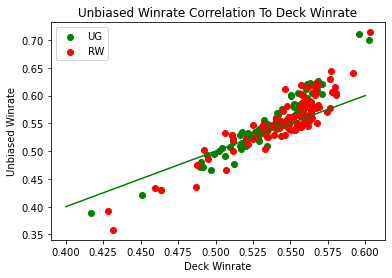

In [32]:
sel = [card for card in khm_ug["name"].values if '//' not in card]
ug = plt.scatter(summary.loc[sel, "deck_winrate"], summary.loc[sel, "unbiased_winrate"], color='green', label="UG")
sel = [card for card in khm_rw["name"].values if '//' not in card]
rw = plt.scatter(summary.loc[sel, "deck_winrate"], summary.loc[sel, "unbiased_winrate"], color='red', label="RW")
plt.plot(np.linspace(0.4,0.6,200),np.linspace(0.4,0.6,200), color='green' )
plt.xlabel('Deck Winrate')
plt.ylabel('Unbiased Winrate')
plt.title("Unbiased Winrate Correlation To Deck Winrate")
plt.legend(handles=[ug,rw])
plt.show()

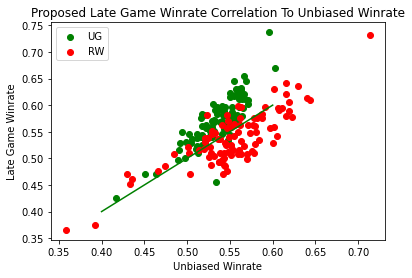

In [33]:
sel = [card for card in khm_ug["name"].values if '//' not in card]
ug = plt.scatter(summary.loc[sel, "deck_winrate"], summary.loc[sel, "late_game_winrate"], color='green', label="UG")
sel = [card for card in khm_rw["name"].values if '//' not in card]
rw = plt.scatter(summary.loc[sel, "unbiased_winrate"], summary.loc[sel, "late_game_winrate"], color='red', label="RW")
plt.plot(np.linspace(0.4,0.6,200),np.linspace(0.4,0.6,200), color='green' )
plt.xlabel('Unbiased Winrate')
plt.ylabel('Late Game Winrate')
plt.title("Proposed Late Game Winrate Correlation To Unbiased Winrate")
plt.legend(handles=[ug,rw])
plt.show()

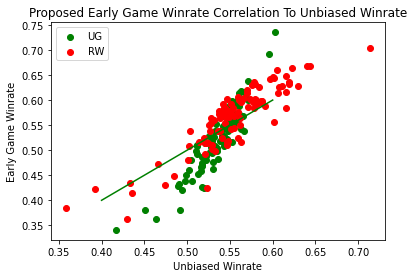

In [35]:
sel = [card for card in khm_ug["name"].values if '//' not in card]
ug = plt.scatter(summary.loc[sel, "deck_winrate"], summary.loc[sel, "early_game_winrate"], color='green', label="UG")
sel = [card for card in khm_rw["name"].values if '//' not in card]
rw = plt.scatter(summary.loc[sel, "unbiased_winrate"], summary.loc[sel, "early_game_winrate"], color='red', label="RW")
plt.plot(np.linspace(0.4,0.6,200),np.linspace(0.4,0.6,200), color='green' )
plt.xlabel('Unbiased Winrate')
plt.ylabel('Early Game Winrate')
plt.title("Proposed Early Game Winrate Correlation To Unbiased Winrate")
plt.legend(handles=[ug,rw])
plt.show()

## Conclusions
What we have shown is:
How to calculate an unbiased estimator of winrate
How to calculate the bias of a winrate estimator
How to select a biased winrate estimator for
    - Early game winrate
    - Late game winrate

Additionally there should be investigation into which of the assumptions I have made about decks:
- On average the number of chances you have had to draw $C_i$ on turn $N$ is $N$ (one card per turn)
- You only have one copy of the card in the deck
- Your deck has 40 cards
impact the winrate statistically significantly. 

Otherwise I think also looking at quadrant theory still has some dividends to think about what it means to be ahead or behind or at partiy in the context of cards drawn. I don't know if the proposed early game winrate metric counts cards that do well to "hold the fort" like walls and whatnot which are not powerful individually, but make your late game better/are role players/get you to the late game. Additionally I would really like to see some analysis on adjusting the analysis for Lessons. The next steps is there should probably be some independent verification on some of these calculations.

Additionally it should be noted that the framework provided has potential application to other things like, winrate over number of cards drawn ect. The only thing needed to create an unbiased estimator for a new metric is:
1. Finite resource that can be counted when the game ends like number of turns or cards drawn
2. Way to calculate likelihood that a card impacts the game when the game ends with the given count of that finite metric. Curretly card drawn if the only one I can think of, though it might be worth it to look into metrics which further isolate card effectiveness. 
3. A way to estimate the probability of the event you are using to evaluate card impact has happened given the count of the finite resource selected in step 1.